In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import sys
sys.path.append('../../')
import jax

jax.config.update("jax_platform_name", "cpu")

from sdebridge.setup import *

2024-01-23 18:28:16.851420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 18:28:16.851489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 18:28:16.852982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 18:28:18.495716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
period = 2 * np.pi
num_grid = 16
z_grid = jnp.fft.fftshift(jnp.fft.fftfreq(num_grid, d=period/num_grid))
print(z_grid)

[-1.2732395  -1.1140846  -0.95492965 -0.7957747  -0.63661975 -0.47746482
 -0.31830987 -0.15915494  0.          0.15915494  0.31830987  0.47746482
  0.63661975  0.7957747   0.95492965  1.1140846 ]


In [51]:
def x_z(x: jnp.ndarray, z):
    M = len(x)
    x_z_complex = jnp.sum(x * jnp.exp(1j * jnp.arange(M) * z)) + z
    return x_z_complex.real + x_z_complex.imag

def gaussian_kernel(x1: ArrayLike, x2: ArrayLike, alpha: float = 1.0, sigma: float = 1.0) -> jnp.ndarray:
    return alpha * jnp.exp(-(x1 - x2)**2 / sigma**2)

def k_matrix(x, z_grid, alpha, sigma):
    x_zs = jax.vmap(x_z, in_axes=(None, 0))(x, z_grid)
    return gaussian_kernel(x_zs[:, None], z_grid[None, :], alpha, sigma)

def inner_product(l, m, k_matrix_, z_grid):
    N = len(z_grid)
    exponents1 = lambda l: jnp.exp(1j * l * z_grid).real + jnp.exp(1j * l * z_grid).imag
    exponents2 = lambda m: jnp.exp(-1j * m * z_grid).real + jnp.exp(-1j * m * z_grid).imag
    return exponents1(l).T @ k_matrix_ @ exponents2(m) * (2 * np.pi / N**2)

@jax.jit
def diffusion(x, z_grid, alpha, sigma):
    M = len(x)
    k = k_matrix(x, z_grid, alpha, sigma)
    _diffusion = vmap(vmap(inner_product, in_axes=(0, None, None, None)), in_axes=(None, 0, None, None))(np.arange(1, M+1), np.arange(1, M+1), k, z_grid)
    return _diffusion

In [50]:
x = jnp.linspace(0, 1.0, 16)
y = 2 * x
alpha = 1.0
sigma = 0.1
kernel1 = gaussian_kernel(x[:, None], y[None, :], alpha, sigma)
kernel2 = gaussian_kernel(x[None, :], y[:, None], alpha, sigma)

print(kernel1[1, 2])
print(gaussian_kernel(x[1], y[2], alpha, sigma))
print(kernel2[1, 2])
print(gaussian_kernel(x[2], y[1], alpha, sigma))

0.01831562
0.01831562
1.0
1.0


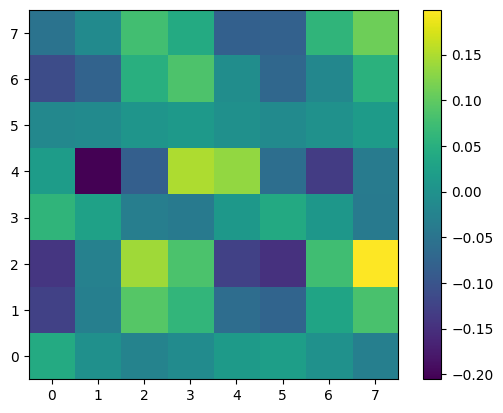

In [52]:
x = jax.random.normal(jax.random.PRNGKey(0), (8, )) * 20
_diffusion = diffusion(x, z_grid, 1.0, 3.0)
plt.imshow(_diffusion, origin='lower')
plt.colorbar()

In [14]:
from sdebridge.data_processing import sample_ellipse
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import CustomizedSDE
from sdebridge.utils import eval_score

/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
complex_to_real = lambda z: jnp.concatenate([z.real, z.imag], axis=0)
real_to_complex = lambda x: x[:len(x)//2] + 1j * x[len(x)//2:]

init_s shape:  (2, 256)
term_s shape:  (2, 256)


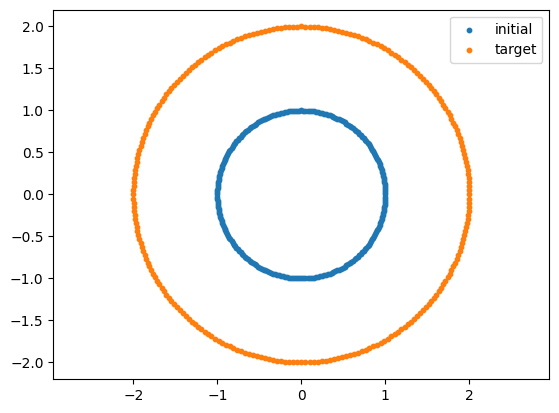

In [28]:
init_s = sample_ellipse(num_points=256, scale=1.0)
term_s = sample_ellipse(num_points=256, scale=2.0)
print("init_s shape: ", init_s.shape)
print("term_s shape: ", term_s.shape)
plt.scatter(init_s[0], init_s[1], s=10, label='initial')
plt.scatter(term_s[0], term_s[1], s=10, label='target')
plt.legend()
plt.axis('equal')
plt.show()

X shape: 
 (2, 256)
X coefficients (complex) shape: 
 (2, 8)
X (reconstructed) shape: 
 (2, 256)
XT (real represented) shape: 
 (2, 16)


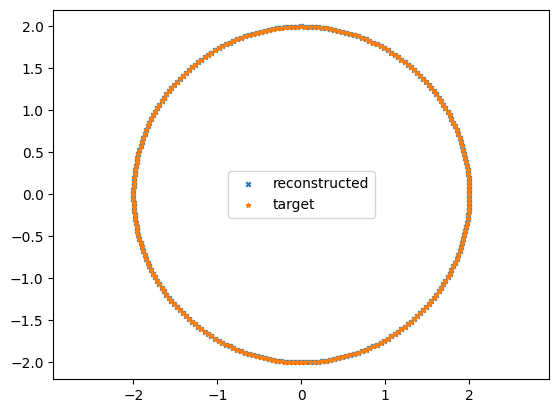

In [29]:
num_truncation = 8
num_samples = init_s.shape[-1]
period = 2.0 * jnp.pi
z_grid = jnp.fft.fftshift(jnp.fft.fftfreq(num_grid, d=period/num_samples))
X0 = jnp.zeros((4*num_truncation, ), dtype=jnp.float32)

displacement = term_s - init_s
print("X shape: \n", displacement.shape)
XT_complex = jnp.fft.rfft2(displacement, norm='backward')[..., :num_truncation]
print("X coefficients (complex) shape: \n", XT_complex.shape)
displacement_recon = jnp.fft.irfft2(XT_complex, norm='backward', s=init_s.shape)
print("X (reconstructed) shape: \n", displacement_recon.shape)

XT = vmap(complex_to_real)(XT_complex)
print("XT (real represented) shape: \n", XT.shape)

term_s_recon = init_s + displacement_recon
plt.scatter(term_s_recon[0], term_s_recon[1], s=10, marker='x', label='reconstructed')
plt.scatter(term_s[0], term_s[1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [39]:
sde_config = ConfigDict()
sde_config.dim = 4*num_truncation
sde_config.N = 100
sde_config.T = 1.0
sde_config.drift = lambda val, time: jnp.zeros_like(val)
sde_config.diffusion = lambda val, time: diffusion(x=val, 
                                                   z_grid=z_grid, 
                                                   alpha=5.0, 
                                                   sigma=10.0)
sde_config.covariance = lambda val, time: sde_config.diffusion(val, time) @ sde_config.diffusion(val, time).T
sde = CustomizedSDE(sde_config)
bridge = DiffusionBridge(sde)
print(sde.config)

N: 100
T: 1.0
covariance: !!python/name:__main__.%3Clambda%3E ''
diffusion: !!python/name:__main__.%3Clambda%3E ''
dim: 32
drift: !!python/name:__main__.%3Clambda%3E ''



In [40]:
forward_uncond = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=1,
)

(1, 100, 2, 16)
(1, 100, 2, 8)
(1, 100, 2, 256)


/home/gefan/tmp/ipykernel_222670/2658623159.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))


(-1.1246767103672028,
 1.179973727464676,
 -1.1228549540042878,
 1.1117981731891633)

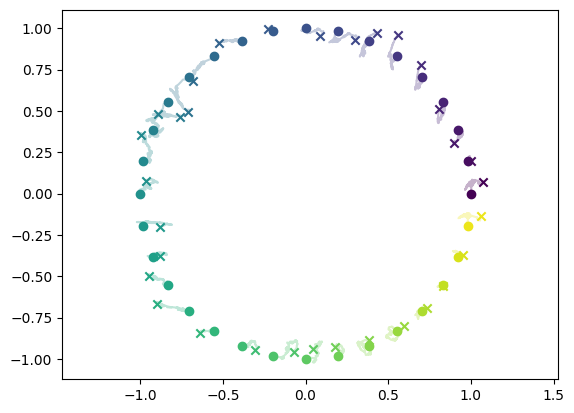

In [41]:
Xs = forward_uncond["trajectories"]
Xs = Xs.reshape((Xs.shape[0], 100, 2, -1))
print(Xs.shape)
coeffs = vmap(vmap(vmap(real_to_complex)))(Xs)
print(coeffs.shape)
displacements = vmap(vmap(partial(jnp.fft.irfft2, norm='backward', s=init_s.shape)))(coeffs)
print(displacements.shape)

ss = displacements + init_s[None, None, :, :]
colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))
for i in jnp.arange(num_samples, step=8):
    plt.scatter(ss[0, 0, 0, i], ss[0, 0, 1, i], marker='o', color=colors[i])
    plt.plot(ss[0, :, 0, i], ss[0, :, 1, i], alpha=0.3, color=colors[i])
    plt.scatter(ss[0, -1, 0, i], ss[0, -1, 1, i], marker='x', color=colors[i])
plt.axis('equal')